The following notebook recreates some of our results on a tiny subset of the data. The full dataset is available on the DTU HPC at location /dtu/blackhole/12/145234

In [1]:
# Cell 1: Import Required Libraries
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report

from split import deterministic_split, random_split
from image_dataset import ImageDataset

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [2]:
# Cell 2: Train Model Function
def train_model(datasets, variants, model_name, base_dir="small_dataset", num_epochs=10, batch_size=4, learning_rate=0.001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Prepare datasets
    _datasets = []
    for dataset, variant in zip(datasets, variants):
        target_dir = os.path.join(base_dir, f"{dataset}/{variant}")
        
        if variant == "real-fewshot":
            target_dir = os.path.join(target_dir, "best" if dataset == "cars" else "seed0")
            train_files, _ = deterministic_split(target_dir, test_ratio=1/6)
        else:
            target_dir = os.path.join(target_dir, "train")
            train_files, _ = random_split(target_dir, train_count=25)
        
        dataset_obj = ImageDataset(file_list=train_files, transform=train_transform, synthetic_label=1 if variant != "real-fewshot" else 0)
        _datasets.append(dataset_obj)
    
    combined_dataset = ConcatDataset(_datasets)
    dataloader_train = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels.data)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / len(combined_dataset):.4f}, Accuracy: {correct_predictions.double() / len(combined_dataset):.4f}")
    
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), f"models/{model_name}.pth")
    print(f"Model saved to models/{model_name}.pth")

In [3]:
# Cell 3: Evaluate Model Function
def evaluate_model(model_name, datasets, variants, base_dir="small_dataset", batch_size=32):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    _datasets = []
    for dataset, variant in zip(datasets, variants):
        target_dir = os.path.join(base_dir, f"{dataset}/{variant}")
        
        if variant == "real-fewshot":
            target_dir = os.path.join(target_dir, "best" if dataset == "cars" else "seed0")
            _, test_files = deterministic_split(target_dir, test_ratio=1/6)
        else:
            target_dir = os.path.join(target_dir, "train")
            _, test_files = random_split(target_dir, train_count=25)
        
        dataset_obj = ImageDataset(file_list=test_files, transform=test_transform, synthetic_label=1 if variant != "real-fewshot" else 0)
        _datasets.append(dataset_obj)
    
    combined_dataset = ConcatDataset(_datasets)
    dataloader_test = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(f"models/{model_name}.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader_test, desc="Inference"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    report = classification_report(all_labels, all_preds, output_dict=True, target_names=["Real", "Synthetic"])
    metrics = {
        "accuracy": report["accuracy"],
        "class_0": report["Real"],
        "class_1": report["Synthetic"]
    }
    return metrics

In [4]:
# Cell 4: Main Script to Train and Evaluate Models
train_datasets = [
    [("cars", "sd2.1"), ("cars", "real-fewshot")],
    [("pets", "sd2.1"), ("pets", "real-fewshot")],
    [("cars", "sd2.1"), ("pets", "sd2.1"), ("cars", "real-fewshot"), ("pets", "real-fewshot")]
]

eval_datasets = [
    [("cars", "dd-fewshot"), ("cars", "real-fewshot")],
    [("cars", "sd2.1"), ("cars", "real-fewshot")],
    [("pets", "sd2.1"), ("pets", "real-fewshot")],
    [("pets", "dd-fewshot"), ("pets", "real-fewshot")]
]

results = {}

for train_combination in train_datasets:
    combined_name = "__".join([f"{dataset}_{variant}" for dataset, variant in train_combination])
    model_name = f"combined_{combined_name}"
    
    if not os.path.exists(f"models/{model_name}.pth"):
        train_model(
            datasets=[dataset for dataset, variant in train_combination],
            variants=[variant for dataset, variant in train_combination],
            model_name=model_name
        )
    
    for eval_combination in eval_datasets:
        eval_name = "__".join([f"{dataset}_{variant}" for dataset, variant in eval_combination])
        metrics = evaluate_model(
            model_name=model_name,
            datasets=[dataset for dataset, variant in eval_combination],
            variants=[variant for dataset, variant in eval_combination]
        )
        results[(model_name, eval_name)] = metrics

# Save results to CSV
import csv
with open("results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Trained_On", "Evaluated_On", "Accuracy", "Class", "Precision", "Recall", "F1-Score"])
    for (trained_on, evaluated_on), metrics in results.items():
        for cls, cls_metrics in metrics.items():
            writer.writerow([trained_on, evaluated_on, metrics["accuracy"], cls, cls_metrics["precision"], cls_metrics["recall"], cls_metrics["f1-score"]])


Dataset small_dataset/cars/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


Epoch 1/10: 100%|██████████| 13/13 [00:02<00:00,  5.88it/s]


Epoch 1/10 - Loss: 0.9674, Accuracy: 0.7347


Epoch 2/10: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Epoch 2/10 - Loss: 0.9348, Accuracy: 0.7755


Epoch 3/10: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Epoch 3/10 - Loss: 0.8146, Accuracy: 0.5918


Epoch 4/10: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


Epoch 4/10 - Loss: 0.5059, Accuracy: 0.7347


Epoch 5/10: 100%|██████████| 13/13 [00:02<00:00,  5.95it/s]


Epoch 5/10 - Loss: 0.3374, Accuracy: 0.8571


Epoch 6/10: 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]


Epoch 6/10 - Loss: 0.4762, Accuracy: 0.7959


Epoch 7/10: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]


Epoch 7/10 - Loss: 0.5564, Accuracy: 0.8367


Epoch 8/10: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]


Epoch 8/10 - Loss: 0.3628, Accuracy: 0.8367


Epoch 9/10: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]


Epoch 9/10 - Loss: 0.3518, Accuracy: 0.8367


Epoch 10/10: 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch 10/10 - Loss: 0.2407, Accuracy: 0.8980
Model saved to models/combined_cars_sd2.1__cars_real-fewshot.pth
Dataset small_dataset/cars/dd-fewshot/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/{m

Dataset small_dataset/cars/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


Inference: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]
/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Dataset small_dataset/pets/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Dataset small_dataset/pets/dd-fewshot/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Dataset small_dataset/pets/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Epoch 1/10: 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]


Epoch 1/10 - Loss: 1.1485, Accuracy: 0.6170


Epoch 2/10: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch 2/10 - Loss: 0.9907, Accuracy: 0.7660


Epoch 3/10: 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]


Epoch 3/10 - Loss: 0.7205, Accuracy: 0.7234


Epoch 4/10: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]


Epoch 4/10 - Loss: 0.8402, Accuracy: 0.5319


Epoch 5/10: 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]


Epoch 5/10 - Loss: 0.5052, Accuracy: 0.7447


Epoch 6/10: 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]


Epoch 6/10 - Loss: 0.6053, Accuracy: 0.7234


Epoch 7/10: 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]


Epoch 7/10 - Loss: 0.3803, Accuracy: 0.8511


Epoch 8/10: 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]


Epoch 8/10 - Loss: 0.4062, Accuracy: 0.8085


Epoch 9/10: 100%|██████████| 12/12 [00:02<00:00,  5.99it/s]


Epoch 9/10 - Loss: 0.6056, Accuracy: 0.7234


Epoch 10/10: 100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


Epoch 10/10 - Loss: 0.3601, Accuracy: 0.8298
Model saved to models/combined_pets_sd2.1__pets_real-fewshot.pth
Dataset small_dataset/cars/dd-fewshot/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/{m

Dataset small_dataset/cars/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


Inference: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]
/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Dataset small_dataset/pets/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Dataset small_dataset/pets/dd-fewshot/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Dataset small_dataset/cars/sd2.1/train
Number of training files: 25
Number of test files: 5
Dataset small_dataset/pets/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Epoch 1/10: 100%|██████████| 24/24 [00:04<00:00,  5.51it/s]


Epoch 1/10 - Loss: 1.2132, Accuracy: 0.6146


Epoch 2/10: 100%|██████████| 24/24 [00:04<00:00,  5.97it/s]


Epoch 2/10 - Loss: 0.5442, Accuracy: 0.7292


Epoch 3/10: 100%|██████████| 24/24 [00:03<00:00,  6.08it/s]


Epoch 3/10 - Loss: 0.5958, Accuracy: 0.7604


Epoch 4/10: 100%|██████████| 24/24 [00:04<00:00,  5.91it/s]


Epoch 4/10 - Loss: 0.5186, Accuracy: 0.7604


Epoch 5/10: 100%|██████████| 24/24 [00:04<00:00,  5.61it/s]


Epoch 5/10 - Loss: 0.5853, Accuracy: 0.7188


Epoch 6/10: 100%|██████████| 24/24 [00:04<00:00,  5.71it/s]


Epoch 6/10 - Loss: 0.6153, Accuracy: 0.7500


Epoch 7/10: 100%|██████████| 24/24 [00:03<00:00,  6.08it/s]


Epoch 7/10 - Loss: 0.5918, Accuracy: 0.7812


Epoch 8/10: 100%|██████████| 24/24 [00:03<00:00,  6.15it/s]


Epoch 8/10 - Loss: 0.5209, Accuracy: 0.7812


Epoch 9/10: 100%|██████████| 24/24 [00:04<00:00,  5.61it/s]


Epoch 9/10 - Loss: 0.5009, Accuracy: 0.8021


Epoch 10/10: 100%|██████████| 24/24 [00:04<00:00,  5.88it/s]


Epoch 10/10 - Loss: 0.4082, Accuracy: 0.8229
Model saved to models/combined_cars_sd2.1__pets_sd2.1__cars_real-fewshot__pets_real-fewshot.pth
Dataset small_dataset/cars/dd-fewshot/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/{m

Dataset small_dataset/cars/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/cars/real-fewshot/best
Number of training files: 24
Number of test files: 6


Inference: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]
/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Dataset small_dataset/pets/sd2.1/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
/var/folders/sg/ypwygzx91294vx0ym7z7rh_c0000gn/T/ipykernel_29924/1671101068.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Dataset small_dataset/pets/dd-fewshot/train
Number of training files: 25
Number of test files: 5
Data dir: small_dataset/pets/real-fewshot/seed0
Number of training files: 22
Number of test files: 8


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


TypeError: 'float' object is not subscriptable

# GradCAM example

The remaining cells of this notebook goes through the process of creating a GradCAM, masking out the car in an image and visualizing these together. It then computes the proportion of the weighted GradCAM activations that lie on the car.

In [2]:
# Cell 5: Import Additional Modules for Grad-CAM and Background Removal
import matplotlib.pyplot as plt

# Import custom classes and functions from the provided scripts
from GradCAM import GradCAM
from remove_background_rmbg import preprocess_image, postprocess_image
from GradCAM_masked_visualize_one import compute_gradcam_outside_proportion_with_visualization

In [3]:
# Cell 6: Select a Synthetic Image for Grad-CAM

# Define the path to the synthetic test dataset
synthetic_test_dir = os.path.join("small_dataset", "cars", "sd2.1", "train")  # Adjust based on your dataset structure

# Initialize the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageDataset(
    file_list=random_split(synthetic_test_dir, train_count=25)[1],  # Assuming synthetic images are in the test split
    transform=test_transform,
    synthetic_label=1  # Label 1 for synthetic
)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

# Select one synthetic image
for inputs, labels in test_dataloader:
    if labels.item() == 1:  # Ensure the image is synthetic
        synthetic_image_tensor = inputs.to("cuda:0" if torch.cuda.is_available() else "cpu")
        synthetic_image_label = labels.item()
        break

print("Selected one synthetic image for Grad-CAM analysis.")

Dataset small_dataset/cars/sd2.1/train
Number of training files: 25
Number of test files: 5
Selected one synthetic image for Grad-CAM analysis.


In [4]:
# Cell 7: Initialize ResNet-18 model (optionally load a finetined version) and Initialize Grad-CAM

# Specify the model name used during training
model_name = "combined_cars_sd2.1__cars_real-fewshot__pets_sd2.1__pets_real-fewshot"

# Load the trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification

# Uncomment the following line to load a pre-trained model
# model.load_state_dict(torch.load(f"models/{model_name}.pth", map_location=device))
model.to(device)
model.eval()

# Initialize Grad-CAM targeting the last convolutional layer
target_layer = model.layer4[1].conv2  # For ResNet18
grad_cam = GradCAM(model, target_layer)

print("Trained model loaded and Grad-CAM initialized.")

Trained model loaded and Grad-CAM initialized.


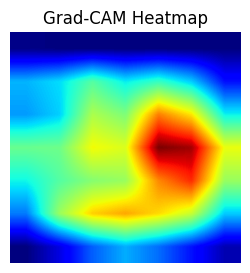

In [5]:
# Cell 8: Compute Grad-CAM for the Selected Synthetic Image

# Perform forward pass and generate Grad-CAM heatmap
output = model(synthetic_image_tensor)
_, pred_class = torch.max(output, 1)

# Generate the Grad-CAM heatmap
heatmap = grad_cam.generate_heatmap(synthetic_image_tensor, pred_class.item())

# Visualize the Grad-CAM heatmap
plt.figure(figsize=(3, 3))
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()

In [6]:
from transformers import AutoModelForImageSegmentation
import torch

# Load the Hugging Face model once
model_name = "briaai/RMBG-1.4"
model = AutoModelForImageSegmentation.from_pretrained(model_name, trust_remote_code=True)

# Determine the device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

BriaRMBG(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

In [7]:
import torch
from transformers import AutoModelForImageSegmentation

def remove_background(preprocessed_image: torch.Tensor, model: AutoModelForImageSegmentation, device: torch.device) -> torch.Tensor:
    """
    Removes the background from a preprocessed image tensor using the provided segmentation model.

    Args:
        preprocessed_image (torch.Tensor): The preprocessed image tensor of shape [1, C, H, W].
        model (AutoModelForImageSegmentation): The pre-trained image segmentation model.
        device (torch.device): The device to run the model on.

    Returns:
        torch.Tensor: The segmentation mask tensor compatible with postprocess_image.
    """
    # Ensure the model is on the correct device and in evaluation mode
    model.to(device)
    model.eval()

    # Move the preprocessed image tensor to the specified device
    preprocessed_image = preprocessed_image.to(device)

    with torch.no_grad():
        # Perform inference to get the segmentation output
        output = model(preprocessed_image)

    # Extract the mask from the model's output
    # The structure of the output may vary depending on the model; adjust accordingly
    if isinstance(output, dict) and 'out' in output:
        mask = output['out'][0][0]  # Assuming 'out' contains the mask tensor
    elif isinstance(output, (list, tuple)) and len(output) > 0:
        mask = output[0][0]  # Assuming the first element contains the mask tensor
    else:
        raise ValueError("Unexpected model output format. Please check the model's documentation.")

    return mask

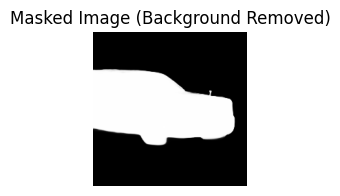

In [8]:
# Cell 9: Remove Background from the Synthetic Image

# Retrieve the original image from the tensor
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
original_image_tensor = unnormalize(synthetic_image_tensor).squeeze().cpu()
original_image = transforms.ToPILImage()(original_image_tensor)

# Convert PIL image to NumPy array
orig_im = np.array(original_image)
orig_im_size = orig_im.shape[0:2]

# Preprocess the image for background removal
model_input_size = [512, 512]  # Adjust if necessary
preprocessed_image = preprocess_image(orig_im, model_input_size).to(device)

no_bg_image = remove_background(preprocessed_image, model, device)
no_bg_image = postprocess_image(no_bg_image, orig_im_size)

plt.figure(figsize=(2, 2))
plt.imshow(no_bg_image, cmap="gray")
plt.axis("off")
plt.title("Masked Image (Background Removed)")
plt.show()


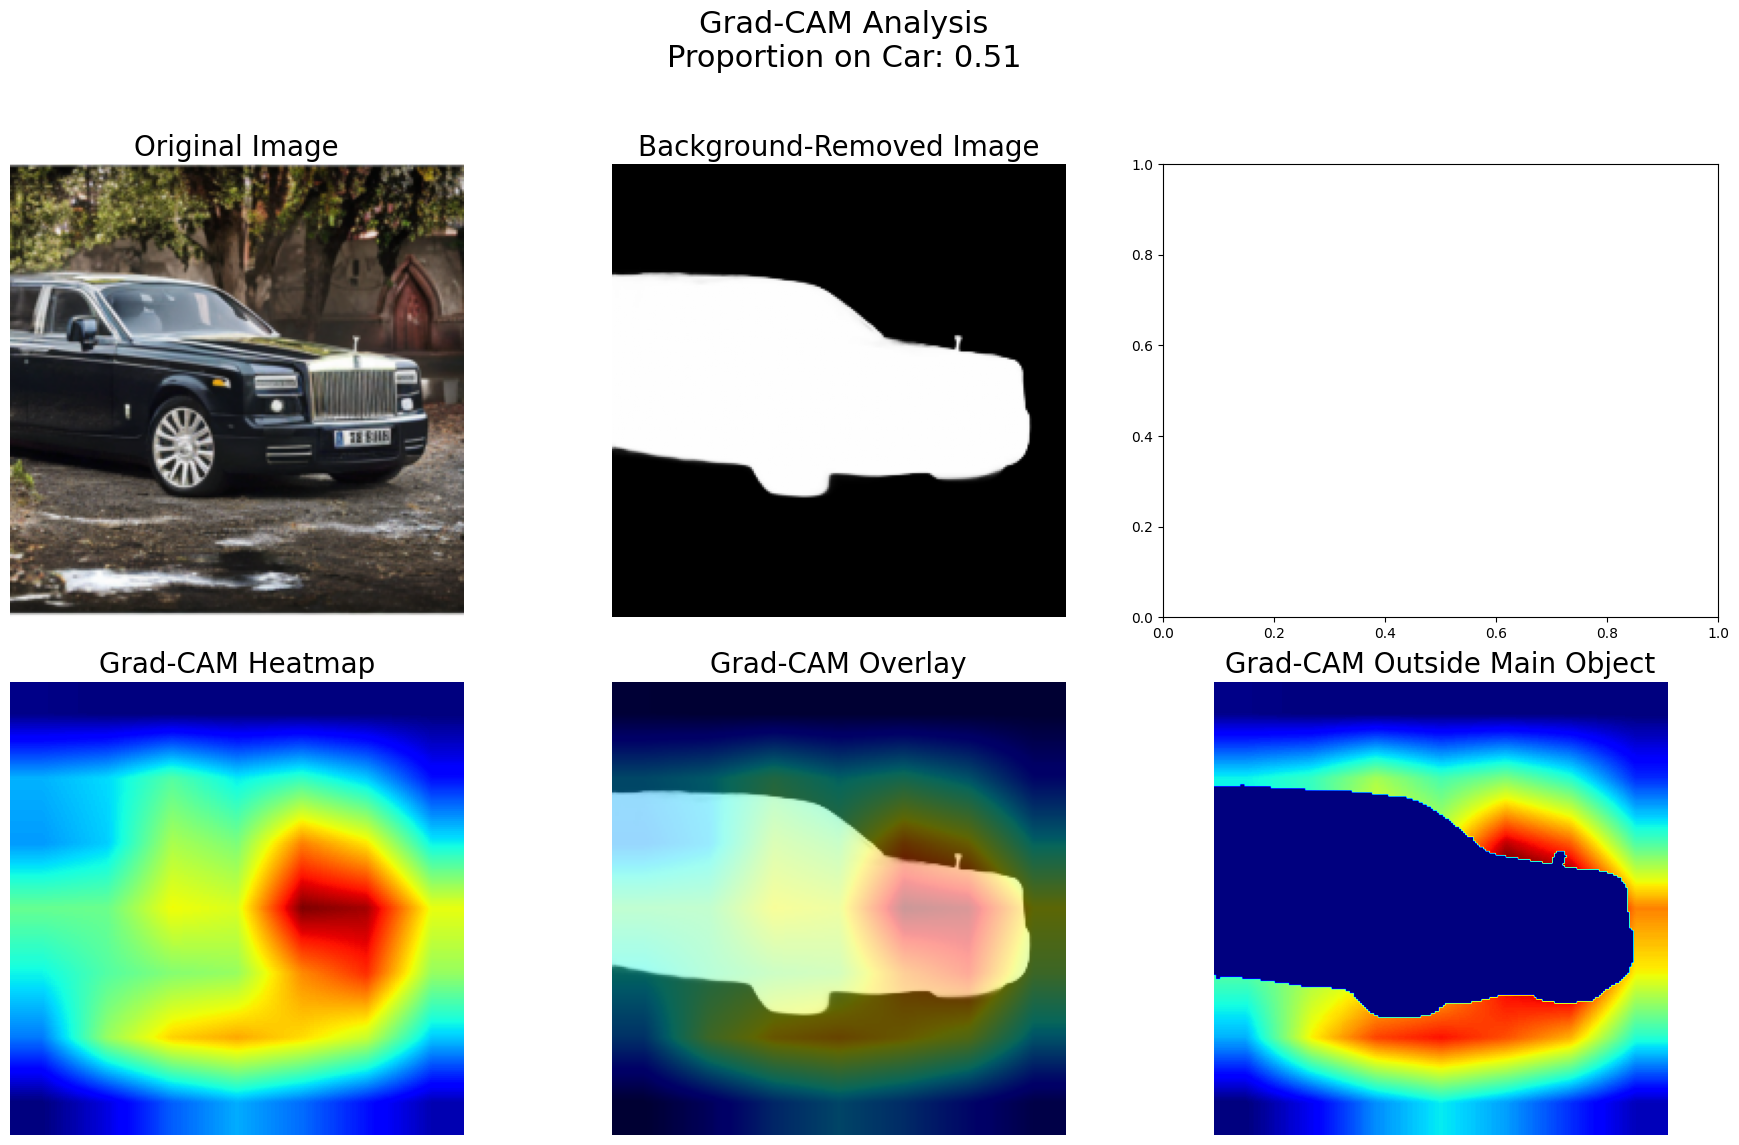

Proportion of Grad-CAM area on car: 0.51


In [9]:
# %%
# Cell 10: Create Grad-CAM Multiplot Visualization

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

def create_gradcam_multiplot(original_image, no_bg_image, heatmap, use_weighted=True):
    """
    Creates a multiplot visualization by overlaying the Grad-CAM heatmap onto the background-removed image,
    displaying the original image, main object mask, Grad-CAM heatmap, overlay, and areas outside the main object.
    
    Parameters:
        original_image (PIL.Image): The original synthetic image.
        no_bg_image (ndarray): Background-removed image as a NumPy array (grayscale).
        heatmap (ndarray): Computed Grad-CAM heatmap.
        use_weighted (bool): Toggle between weighted and binary Grad-CAM activations.
    
    Returns:
        visualization (ndarray): The resulting visualization as a NumPy array.
        proportion_outside (float): Proportion of Grad-CAM area outside the main object.
    """
    # ===========================
    # Step 1: Prepare the Images and Heatmap
    # ===========================

    # Ensure no_bg_image is a NumPy array
    if isinstance(no_bg_image, Image.Image):
        no_bg_image_np = np.array(no_bg_image.convert('L'))
    elif isinstance(no_bg_image, np.ndarray):
        no_bg_image_np = no_bg_image
    else:
        raise TypeError(f"Unsupported type for no_bg_image: {type(no_bg_image)}")
    
    # Convert original_image to RGB NumPy array
    original_np = np.array(original_image.convert('RGB')).astype(np.float32) / 255.0
    
    # Convert no_bg_image to RGB by stacking if it's grayscale
    if no_bg_image_np.ndim == 2:
        no_bg_rgb = np.stack([no_bg_image_np]*3, axis=-1).astype(np.float32) / 255.0
    elif no_bg_image_np.ndim == 3 and no_bg_image_np.shape[2] == 4:
        # If RGBA, convert to RGB by removing alpha channel
        no_bg_rgb = no_bg_image_np[:, :, :3].astype(np.float32) / 255.0
    elif no_bg_image_np.ndim == 3 and no_bg_image_np.shape[2] == 3:
        no_bg_rgb = no_bg_image_np.astype(np.float32) / 255.0
    else:
        raise ValueError(f"Unexpected shape for no_bg_image_np: {no_bg_image_np.shape}")
    
    # Create main object mask (binary)
    main_object_mask = (no_bg_image_np > 0).astype(np.uint8)
    
    # Resize heatmap to match image size
    original_size = original_image.size  # (width, height)
    heatmap_pil = Image.fromarray(np.uint8(255 * heatmap)).resize(original_size, resample=Image.BILINEAR)
    heatmap_resized_np = np.array(heatmap_pil).astype(np.float32) / 255.0  # Normalize to [0,1]
    
    # Apply colormap to heatmap
    heatmap_colored = plt.get_cmap('jet')(heatmap_resized_np)[:, :, :3]  # Remove alpha channel
    
    # ===========================
    # Step 2: Compute Proportion Outside Main Object
    # ===========================
    if use_weighted:
        total_gradcam_area = np.sum(heatmap_resized_np)
        if total_gradcam_area == 0:
            proportion_outside = 0.0
        else:
            outside_area = np.sum(heatmap_resized_np * (main_object_mask == 0))
            proportion_outside = outside_area / total_gradcam_area
        threshold_method = "Weighted Grad-CAM"
    else:
        # Determine the Threshold using Otsu's method
        try:
            threshold = threshold_otsu(heatmap_resized_np)
            # Handle case where all values are the same
            if np.isnan(threshold):
                print(f"Otsu's threshold returned NaN for heatmap. Using threshold=0.5")
                threshold = 0.5
        except Exception as e:
            print(f"Error computing Otsu's threshold: {e}")
            threshold = 0.5  # Default threshold
        threshold_method = "Otsu's Threshold"
        
        # Create binary Grad-CAM mask
        gradcam_mask = (heatmap_resized_np >= threshold).astype(np.uint8)
        
        # Compute proportion outside
        total_gradcam_area = np.sum(gradcam_mask)
        if total_gradcam_area == 0:
            proportion_outside = 0.0
        else:
            outside_area = np.sum((gradcam_mask == 1) & (main_object_mask == 0))
            proportion_outside = outside_area / total_gradcam_area

    # ===========================
    # Step 3: Create Overlay
    # ===========================
    if use_weighted:
        overlay = (no_bg_rgb * 0.6 + heatmap_colored * 0.4)
    else:
        # Apply colormap to binary mask
        heatmap_colored = plt.get_cmap('jet')(gradcam_mask)[:, :, :3]
        overlay = (no_bg_rgb * 0.6 + heatmap_colored * 0.4)
    overlay = np.clip(overlay, 0, 1)
    visualization = (overlay * 255).astype(np.uint8)
    
    # ===========================
    # Step 4: Identify Areas Outside Main Object
    # ===========================
    if use_weighted:
        outside_gradcam = heatmap_resized_np * (main_object_mask == 0)
    else:
        outside_gradcam = gradcam_mask * (main_object_mask == 0)
    
    # ===========================
    # Step 5: Generate Multiplot
    # ===========================
    proportion_inside = 1 - proportion_outside
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"Grad-CAM Analysis\nProportion on Car: {proportion_inside:.2f}", fontsize=22)
    
    # Flatten axes for easy indexing
    axes_flat = axes.flatten()
    
    # Subplot 1: Original Image
    axes_flat[0].imshow(original_np)
    axes_flat[0].set_title('Original Image', fontsize=20)
    axes_flat[0].axis('off')
    
    # Subplot 2: Background-Removed Image
    axes_flat[1].imshow(no_bg_rgb)
    axes_flat[1].set_title('Background-Removed Image', fontsize=20)
    axes_flat[1].axis('off')

    
    # Subplot 4: Grad-CAM Heatmap
    axes_flat[3].imshow(heatmap_resized_np, cmap='jet')
    axes_flat[3].set_title('Grad-CAM Heatmap', fontsize=20)
    axes_flat[3].axis('off')
    
    # Subplot 5: Grad-CAM Overlay on Image
    axes_flat[4].imshow(visualization)
    axes_flat[4].set_title('Grad-CAM Overlay', fontsize=20)
    axes_flat[4].axis('off')
    
    # Subplot 6: Grad-CAM Outside Main Object
    axes_flat[5].imshow(outside_gradcam, cmap='jet')
    axes_flat[5].set_title('Grad-CAM Outside Main Object', fontsize=20)
    axes_flat[5].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.show()
    
    print(f"Proportion of Grad-CAM area on car: {proportion_inside:.2f}")


create_gradcam_multiplot(original_image, no_bg_image, heatmap, use_weighted=True)